In [8]:

import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv("./data/profit-data.csv")

dataset.head()
print(dataset)
x = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 4].values



        R&D Spend  Administration  Marketing Spend       State     Profit
0       165349.20       136897.80        471784.10    New York  192261.83
1       162597.70       151377.59        443898.53  California  191792.06
2       153441.51       101145.55        407934.54     Florida  191050.39
3       144372.41       118671.85        383199.62    New York  182901.99
4       142107.34        91391.77        366168.42     Florida  166187.94
5       131876.90        99814.71        362861.36    New York  156991.12
6       134615.46       147198.87        127716.82  California  156122.51
7       130298.13       145530.06        323876.68     Florida  155752.60
8       120542.52       148718.95        311613.29    New York  152211.77
9       123334.88       108679.17        304981.62  California  149759.96
10      101913.08       110594.11        229160.95     Florida  146121.95
11      100671.96        91790.61        249744.55  California  144259.40
12       93863.75       127320.38     

<Axes: >

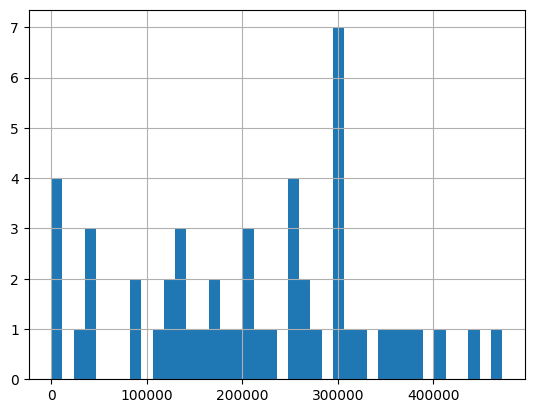

In [18]:
num_cols = len(dataset.columns)
# Crear una lista de nombres nuevos
nuevos_nombres = [ i for i in range(num_cols)]

# Asignar los nuevos nombres a las columnas
dataset.columns = nuevos_nombres

dataset = dataset.rename(columns={0: "R_D_Spend", 1: "Administration", 2: "Marketing_Spend", 3:'State', 4:'Profit'})
dataset.Profit.hist(bins=40)

Viendo correlaciones

In [ ]:
import matplotlib.pyplot  as plt
import seaborn as sns
sns.pairplot(dataset, height=2.5)
plt.show()

2. Categorización de datos

In [16]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [3])],   
    remainder='passthrough'                        
)
x_transformado = np.array(ct.fit_transform(x), dtype=np.double)
x_transformado = x_transformado[:,1:]
dataset = pd.DataFrame(x_transformado)

dataset = dataset.rename(columns={0: "nueva_york", 1: "Florida", 2: "R_D_Spend", 3: "Administration", 4: "Marketing_Spend"})


In [6]:
print(dataset.shape)


(50, 5)


3. Division de datos de entrenamiento y test

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_transformado, y, test_size=0.2, random_state=0)
dataset = pd.DataFrame(x_train)
dataset = dataset.rename(columns={0: "nueva_york", 1: "Florida", 2: "R_D_Spend", 3: "Administration", 4: "Marketing_Spend"})

print(dataset)

    nueva_york  Florida  R_D_Spend  Administration  Marketing_Spend
0          1.0      0.0   55493.95       103057.49        214634.81
1          0.0      1.0   46014.02        85047.44        205517.64
2          1.0      0.0   75328.87       144135.98        134050.07
3          0.0      0.0   46426.07       157693.92        210797.67
4          1.0      0.0   91749.16       114175.79        294919.57
5          1.0      0.0  130298.13       145530.06        323876.68
6          1.0      0.0  119943.24       156547.42        256512.92
7          0.0      1.0    1000.23       124153.04          1903.93
8          0.0      1.0     542.05        51743.15             0.00
9          0.0      1.0   65605.48       153032.06        107138.38
10         0.0      1.0  114523.61       122616.84        261776.23
11         1.0      0.0   61994.48       115641.28         91131.24
12         0.0      0.0   63408.86       129219.61         46085.25
13         0.0      0.0   78013.11       121597.

4. Ajustar el modelo de regresion lineal  mutiple con el conjunto de entrenamiento

In [37]:
from sklearn.linear_model import LinearRegression
regresion = LinearRegression();
regresion.fit(x_train, y_train)

LinearRegression()

5. Prediccion de los resultados en el conjunto de testig

In [38]:
y_prediccion = regresion.predict(x_test)
#print(y_prediccion)

In [39]:
from joblib import dump
dump(regresion, './model/model-profit.pkl')

['./model/model-profit.pkl']

6. Construir el modelo óptimo del RLM utilizando la eliminacion hacia atrás

In [43]:
import statsmodels.formula.api as sm
x_transformado = np.append(arr=np.ones((50,1)).astype(int), values=x_transformado, axis=1)

x_transformado = np.append(y.reshape(-1, 1) , x_transformado, axis=1 )
dataset = pd.DataFrame(x_transformado)
print(dataset)

#dataset = pd.DataFrame(x_transformado)
arr2_reshaped = y.reshape(-1, 1)
#print(dataset)

x_transformado = x_transformado [:, [0,1,2,3,4,5,6]]
sl= 0.05




model = sm.ols(formula='y ~ x1 + x2 + x3 + x4 + x5 + x6', data=x_transformado)
#dataset = pd.DataFrame(x_transformado)
#dataset = pd.DataFrame(y)

#print(dataset)
#print(dataset)

#print(x_opt)
#regresion_ols = sm.ols(endog=y,exog = x_opt).fit()
#regresion_ols.sumary()

ModuleNotFoundError: No module named 'statsmodels'

In [1]:
import statsmodels.formula.api as smf
import pandas as pd

# Crear un DataFrame de ejemplo para la variable endógena (y) y exógena (X)
data = {
    'y': [1, 2, 3, 4, 5],  # Variable endógena
    'x1': [1, 2, 3, 4, 5],  # Variables exógenas
    'x2': [2, 3, 4, 5, 6],
    'x3': [3, 4, 5, 6, 7],
    'x4': [4, 5, 6, 7, 8],
    'x5': [5, 6, 7, 8, 9]
}
df = pd.DataFrame(data)
print(df)
# Ajustar un modelo de regresión lineal múltiple usando fórmulas
model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=df)
result = model.fit()

# Imprimir un resumen del modelo ajustado
print(result.summary())


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
import pandas as pd

# Suponiendo que tienes dos DataFrames llamados df1 y df2, donde df1 es de 4x5 y df2 es de 4x1
df1 = pd.DataFrame({"Columna1": range(1, 5),
                    "Columna2": range(5, 9),
                    "Columna3": range(9, 13),
                    "Columna4": range(13, 17),
                    "Columna5": range(17, 21)})

df2 = pd.DataFrame({"Columna6": range(21, 25)})

# Unir los DataFrames a lo largo del eje de las columnas (eje 1)
df_concatenado = pd.concat([df1, df2], axis=1)

# Imprimir el DataFrame resultante
print(df_concatenado)


   Columna1  Columna2  Columna3  Columna4  Columna5  Columna6
0         1         5         9        13        17        21
1         2         6        10        14        18        22
2         3         7        11        15        19        23
3         4         8        12        16        20        24
